In [ ]:
import cv2
import dlib
import pickle
import warnings
import numpy as np
import pandas as pd
import seaborn as sns
from numpy import asarray
from PIL import Image

import urllib.request

from sklearn import metrics
from scipy.spatial import distance
from sklearn.metrics import accuracy_score
from matplotlib import pyplot as plt
from tqdm import tqdm,tqdm_pandas
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

import re
import gdown
import keras

from keras.models import Sequential
from keras.utils import to_categorical
from keras.optimizers import Adam
from keras.layers import Dense, Dropout, Activation, Flatten
from keras.layers import Conv2D, MaxPooling2D, BatchNormalization
from keras.losses import categorical_crossentropy
from keras.optimizers import Adam, SGD
from keras.regularizers import l2
from keras.callbacks import EarlyStopping, ModelCheckpoint
from keras.models import load_model

import keras
from keras.layers import Activation, MaxPooling2D, Dropout, Flatten, Reshape, Dense, Conv2D, GlobalAveragePooling2D
from keras.wrappers.scikit_learn import KerasClassifier
import keras.optimizers as optimizers
from keras.applications.vgg16 import VGG16

import tensorflow as tf
from keras.models import Sequential
from keras.layers import Activation, Dropout, Flatten, Dense
from keras import optimizers

warnings.filterwarnings("ignore")
def model_to_string(model):
    import re
    stringlist = []
    model.summary(print_fn=lambda x: stringlist.append(x))
    sms = "\n".join(stringlist)
    sms = re.sub('_\d\d\d','', sms)
    sms = re.sub('_\d\d','', sms)
    sms = re.sub('_\d','', sms)  
    return sms


###Getting the Xpure loaded
pureX_url = 'https://drive.google.com/uc?id=1CglpXodenZVrkaZehLtfykfQv8dcnfO9'
pureX_path = './pureX.npy'
gdown.download(pureX_url, pureX_path,True)


###Getting the Ydata loaded
dataY_url = 'https://drive.google.com/uc?id=1Rfr0OP-hZO_UZfuOyMNR2RjNRAro85zE'
dataY_path = './dataY.npy'
gdown.download(dataY_url, dataY_path, True)

print ("Data Downloaded!")


#Integer to Label Mapping
label_map = {"0":"ANGRY","1":"HAPPY","2":"SAD","3":"SURPRISE","4":"NEUTRAL"}

Data Downloaded!


In [ ]:
# the number of times we pass all the training data through the model 
epochs = 500
# the number of examples we pass to the model at each time
batch_size = 256
# the proportion of testing data we set aside (e.g. 10%)
test_ratio = .1
# the number of emotion categories we have to predict
n_labels = 5 
# the width and height of the images
width, height = 48, 48

In [ ]:
# load unprocessed data 
dataX_pixels = np.load('pureX.npy')
dataY_pixels = np.load('dataY.npy')

In [ ]:
# convert labels to one hot encoding
y_onehot = keras.utils.to_categorical(dataY_pixels, len(set(dataY_pixels)))

In [ ]:
# split Data into Train, Test (90-10)
X_train, X_test, y_train, y_test = train_test_split(dataX_pixels, y_onehot, test_size=test_ratio, random_state=42)
#Standardize the data
pixel_scaler = StandardScaler()
pixel_scaler.fit(X_train)
X_train = pixel_scaler.transform(X_train)
X_test = pixel_scaler.transform(X_test)
#Turn the data into a format the CNN will understand
X_train_cnn = X_train.reshape(len(X_train),height,width)
X_test_cnn = X_test.reshape(len(X_test),height,width)

In [ ]:
# load the vgg network that is an 'expert' at 'imagenet' but do not include the FC layers
vgg_expert = VGG16(weights = 'imagenet', include_top = False, input_shape = (48, 48, 3))

# we add the first 12 layers of vgg to our own model vgg_model
vgg_model = Sequential()
vgg_model.add(vgg_expert)

# and then add our own layers on top of it
vgg_model.add(GlobalAveragePooling2D())
vgg_model.add(Dense(1024, activation = 'tanh'))
vgg_model.add(Dropout(0.5))
vgg_model.add(Dense(1024, activation = 'tanh'))
vgg_model.add(Dropout(0.5))
vgg_model.add(Dense(1024, activation = 'tanh'))
vgg_model.add(Dropout(0.5))
vgg_model.add(Dense(5, activation = 'sigmoid'))

#build the vgg model
vgg_model.compile(loss = 'categorical_crossentropy', 
          optimizer = optimizers.SGD(lr=1e-4, momentum=0.95), 
          metrics=['accuracy'])

X_TRAIN = np.array([np.transpose(np.array([X_train_cnn[ix].squeeze() for i in range(3)]), (1,2,0)) for ix in range(len(X_train))])
X_TEST = np.array([np.transpose(np.array([X_test_cnn[ix].squeeze() for i in range(3)]), (1,2,0)) for ix in range(len(X_test))])

checkpoint = ModelCheckpoint('best_VGG_model.h5', verbose=1, monitor='val_loss',save_best_only=True, mode='auto')
early = EarlyStopping(monitor='val_loss', min_delta=0, patience=25, verbose=1, mode='auto')

#training the model
vgg_history = vgg_model.fit(X_TRAIN, y_train,
          batch_size=batch_size,
          epochs=epochs,
          verbose=1,
          callbacks=[checkpoint, early],
          validation_data=(X_TEST, y_test),
          shuffle=True)

58892288/58889256 [==============================] - 1s 0us/step
Epoch 1/500
71/71 [==============================] - 54s 238ms/step - loss: 1.9203 - accuracy: 0.2069 - val_loss: 1.5114 - val_accuracy: 0.3740

Epoch 00001: val_loss improved from inf to 1.51138, saving model to best_VGG_model.h5
Epoch 2/500
71/71 [==============================] - 13s 178ms/step - loss: 1.5378 - accuracy: 0.3045 - val_loss: 1.4167 - val_accuracy: 0.4180

Epoch 00002: val_loss improved from 1.51138 to 1.41671, saving model to best_VGG_model.h5
Epoch 3/500
71/71 [==============================] - 13s 180ms/step - loss: 1.4501 - accuracy: 0.3558 - val_loss: 1.3686 - val_accuracy: 0.4450

Epoch 00003: val_loss improved from 1.41671 to 1.36856, saving model to best_VGG_model.h5
Epoch 4/500
71/71 [==============================] - 13s 182ms/step - loss: 1.3931 - accuracy: 0.3956 - val_loss: 1.2776 - val_accuracy: 0.4640

Epoch 00004: val_loss improved from 1.36856 to 1.27763, saving model to best_VGG_model.h5

In [ ]:
#Save the models
vgg_model.save("vgg_model.h5")
vgg_model.save("vgg_model.model")

INFO:tensorflow:Assets written to: vgg_model.model/assets


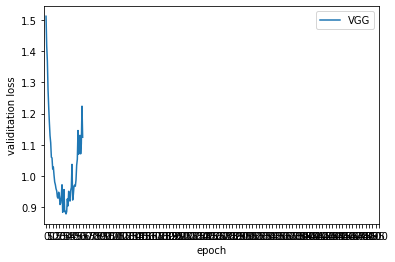

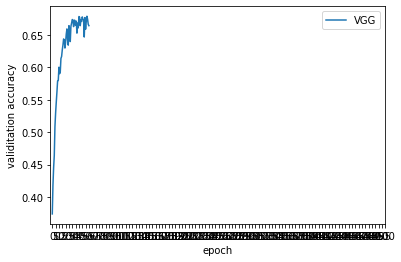

In [ ]:
plt.plot(vgg_history.history['val_loss'])
plt.ylabel('validitation loss')
plt.xlabel('epoch')
plt.legend(['VGG'], bbox_to_anchor=[1,1])
plt.xticks(range(0, epochs+1, 5), range(0, epochs+1, 5))
plt.show()
plt.plot(vgg_history.history['val_accuracy'],)
plt.ylabel('validitation accuracy')
plt.xlabel('epoch')
plt.legend(['VGG'], bbox_to_anchor=[1,1])
plt.xticks(range(0, epochs+1, 5), range(0, epochs+1, 5))
plt.show()

In [ ]:
from IPython.display import display, Javascript
from google.colab.output import eval_js
from base64 import b64decode

def take_photo(filename='photo.jpg', quality=0.8):
  js = Javascript('''
    async function takePhoto(quality) {
      const div = document.createElement('div');
      const capture = document.createElement('button');
      capture.textContent = 'Capture';
      div.appendChild(capture);

      const video = document.createElement('video');
      video.style.display = 'block';
      const stream = await navigator.mediaDevices.getUserMedia({video: true});

      document.body.appendChild(div);
      div.appendChild(video);
      video.srcObject = stream;
      await video.play();

      // Resize the output to fit the video element.
      google.colab.output.setIframeHeight(document.documentElement.scrollHeight, true);

      // Wait for Capture to be clicked.
      await new Promise((resolve) => capture.onclick = resolve);

      const canvas = document.createElement('canvas');
      canvas.width = video.videoWidth;
      canvas.height = video.videoHeight;
      canvas.getContext('2d').drawImage(video, 0, 0);
      stream.getVideoTracks()[0].stop();
      div.remove();
      return canvas.toDataURL('image/jpeg', quality);
    }
    ''')
  display(js)
  data = eval_js('takePhoto({})'.format(quality))
  binary = b64decode(data.split(',')[1])
  with open(filename, 'wb') as f:
    f.write(binary)
  return filename

In [ ]:
from IPython.display import Image
try:
  filename = take_photo()
  print('Saved to {}'.format(filename))
  
  # Show the image which was just taken.
  display(Image(filename))
except Exception as err:
  # Errors will be thrown if the user does not have a webcam or if they do not
  # grant the page permission to access it.
  print(str(err))

<IPython.core.display.Javascript object>

'NoneType' object has no attribute 'split'


In [ ]:
from PIL import Image
im = Image.open('photo.jpg').convert("L")
w, h = im.size   # Get dimensions
box = h if h <= w else w

left = round((w - box)/2)
top = round((h - box)/2)
x_right = round(w - box) - left
x_bottom = round(h - box) - top
right = w - x_right
bottom = w - x_bottom

# Crop the center of the image
im = im.crop((left, top, right, bottom))
im = im.resize((48,48))
im.save('what.png')

data = cv2.imread("what.png", cv2.IMREAD_GRAYSCALE)

#Turn the data into a format the CNN will understand
data = data.reshape(1, 48, 48)
#data = np.array([np.transpose(np.array([data[ix].squeeze() for i in range(3)]), (1,2,0)) for ix in range(len(data))])
data = np.array([np.transpose(np.array([data[ix].squeeze() for i in range(3)]), (1,2,0)) for ix in range(len(data))])

print(data.shape)
print(X_train_cnn[0].shape)

pred = vgg_model.predict(data)
emotions = ["Angry","Happy","Sad","Surprise","Neutral"]
pred_emotion = emotions[np.argmax(pred)]
print(pred, pred_emotion)

FileNotFoundError: ignored